# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
# We import both the weighted and unweighted symmetric adjacency matrices, and set the diagonal 
# to zero (remember that in Milestone 2 we found out that we had one self loop)

# the unweighted adjacency matrix
adjacency_uw =  np.load('data/adjacency_sym_mtx_uw.npy') 

# the weighted adjacency matrix
adjacency =  np.load('data/adjacency_sym_mtx.npy')  

# the number of nodes in the network
n_nodes =  adjacency_uw.shape[0] 

# set diagonal elements to 0 (as explained in Milestone 2)
adjacency_uw[np.diag_indices_from(adjacency_uw)] = 0 
adjacency[np.diag_indices_from(adjacency)] = 0

# the number of edges in the network
n_edges =  adjacency_uw.sum() / 2 

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
# we use the weighted adjacency matrix (named adjacency)
laplacian_combinatorial =  sparse.csgraph.laplacian(adjacency, normed=False).astype('float64')
laplacian_normalized =  sparse.csgraph.laplacian(adjacency, normed=True)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
# Variable used in the rest of the milestone, to change easily between normalized and combinatorial
laplacian = laplacian_combinatorial

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [6]:
def is_sorted(a):
    for i in range(a.size-1):
         if a[i+1] < a[i] :
            return False
    return True

In [7]:
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian)

In [8]:
print("Check sorted :", is_sorted(eigenvalues))
print(eigenvectors.shape)

assert eigenvectors.shape == (n_nodes, n_nodes)

Check sorted : True
(3179, 3179)


In [9]:
# We have used this code in order to check if the computation of the eigenvalues and eigenvectors 
# was correct and satisfied the property of eigenvalues/vectors
idx = 1
u = eigenvectors[:, idx]
c = laplacian.dot(u)

for i in range(3178) :
    a = eigenvalues[i] * u
    if (np.allclose(a,c, 1e-20)) :
        print('TRUE almost equal :', i)    
    if (np.array_equal(a,c)) :
        print('TRUE equal :', i)

TRUE almost equal : 0
TRUE almost equal : 1
TRUE almost equal : 2
TRUE almost equal : 3
TRUE almost equal : 4
TRUE almost equal : 5
TRUE almost equal : 6


Justify your choice of eigensolver.


Since we know our matrix is symmetric, we use the scipy.linalg.eigh function which is designed for this situation, and implements a faster algorithm than scipy.linalg.eig (which works for any kind of matrix). <br>
Moreover scipy.linalg.eigh returns the eigenvalues in ascending order. <br>

We could have taken numpy.linalg.eigh instead, since it doesn't change anything. The advantage of scipy.linalg.eigh is that it has more functionnalities. For example, it can take a second matrix as an argument, but we don't use it here, so it doesn't make any difference. <br>

sparse.linalg.eigs provides a fast way to get the first k << N eigenvalues of a sparse matrix, using a partial decomposition, with Lanczos algorithm. However it is not made for computing all the eigenvalues : it approximates the values of the eigenvalues, and we get a RunTime Warning when trying to do so. Hence it is not good for computing all the eigenvalues, so we don't use it for this question.



### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

Matrix $S$ is the **incidence matrix** whose elements are equal to $0$ or $\pm 1$. The rows are for nodes and columns for edges. $S(i,j)$ is equal to $+1$ if there is an edge $e_j = (v_i, v_k)$ and is equal to $-1$ if there is an edge $e_j = (v_k, v_i)$ for some node $k$. It is equal to $0$ otherwise.

If there is a signal $x \in \mathbb{R}^N$ then $S^\top x$ computes **the gradient of $x$**. It is a generalization of the fact that $(S^\top x)[j] = x[i] - x[k]$ is a derivative of $x$ along edge $j$.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

$\| S^\top u_k \|_2^2 =  u_k^\top S S^\top u_k = u_k^\top L u_k$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; and while $u_k = D^{-1/2}f_k$ where $D$ is a diagonal degree matrix we can write

$=(D^{-1/2}f_k)^\top L D^{-1/2}f_k$

$=f_k^\top (D^{-1/2})^\top L D^{-1/2}f_k$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; as $D$ is diagonal we know that $D=D^\top$ and $L_{norm} = D^{-1/2} L D^{-1/2}$ we can deduce

$=f^\top L_{norm} f_k$

$=\lambda_k$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the desired eigenvalue

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

It is a quadratic Dirichlet form, a measure of how smooth a signal $x$ is.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

In [10]:
eigenvalues_comb, eigenvectors_comb = scipy.linalg.eigh(laplacian_combinatorial)
eigenvalues_norm, eigenvectors_norm = scipy.linalg.eigh(laplacian_normalized)

In [11]:
u0_comb = eigenvectors_comb[:,0]
u0_norm = eigenvectors_norm[:,0]
print("Combinatorial u0 : \n", u0_comb)
print("min (absolute) value : ", np.min(np.absolute(u0_comb)))
print("max (absolute) value : ", np.max(np.absolute(u0_comb)))
print("\nNormalized u0 : \n", u0_norm)
print("min (absolute) value : ", np.min(np.absolute(u0_norm)))
print("max (absolute) value : ", np.max(np.absolute(u0_norm)))

Combinatorial u0 : 
 [-0.00182848 -0.00182848 -0.00182848 ... -0.00182848 -0.00182848
 -0.00182848]
min (absolute) value :  0.001828476411040059
max (absolute) value :  0.42269718615977814

Normalized u0 : 
 [-3.97341103e-07 -5.25632873e-07 -5.96011655e-07 ... -2.80962589e-07
 -1.98670552e-07 -1.98670552e-07]
min (absolute) value :  1.986705513961434e-07
max (absolute) value :  0.6123721833724121


In [12]:
print("Min eigenvalue (combinatorial):", eigenvalues_comb[0])
print("Min eigenvalue (normalized):", eigenvalues_norm[0])

Min eigenvalue (combinatorial): -4.2556827389280264e-15
Min eigenvalue (normalized): -5.447251714378942e-16


The value of $u_0$ for the combinatorial and normalized laplacians, is a vector composed of positive and negative numbers, whose absolute values are in the ranges showed above.<br>
We cannot see any particular properties about these vectors, because they are computed on the whole adjacency matrix of the graph, ie. composed of several connected components. <br>
Also it is very difficult so say something about them, because we don't know if the difference between all the values is due to the approximation done by the function scipy.linalg.eigh, or if the values are actually differents. For example, the smallest eigenvalue for the combinatorial laplacian is given by $-7.511050221243483e-15$. This value is extremely small, so we could approximate it by zero, but we might also loose some information by doing that (such as the sign of the minimal eigenvalue)!

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

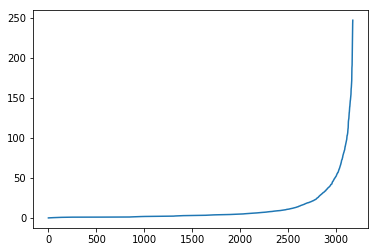

In [13]:
plt.plot(eigenvalues)

**Your answer here.**

We can see that the eigenvalues' values are rising exponentially, an abrupt increase takes place around the last fifth.

//
Null space not that visible... Is something to be said on that point?

How many connected components are there in your graph? Answer using the eigenvalues only.

In [14]:
min_value = eigenvalues[0]

n_components = np.count_nonzero(eigenvalues == min_value)
n_components

7

**Comments :** <br>
Since we don't have values exactly equal to zero among our eigenvalues, we have considered the minimal value as being an approximation of zero (cf. comment of question 5 also). The number of connected components is given by the number of eigenvalues equal to zero (here equal to the minimal value). <br>
The result we got is consistent with what we got in Milestone 2, so we think it is a good approximation.

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

In [15]:
print("Max eigenvalue for combinatorial:",max(eigenvalues_comb))
print("Max eigenvalue for normalized:",max(eigenvalues_norm))
print("Norm of order 2 of combinatorial Laplacian:", np.linalg.norm(laplacian_combinatorial,2))

Max eigenvalue for combinatorial: 247.2158761015632
Max eigenvalue for normalized: 2.0000000000000004
Norm of order 2 of combinatorial Laplacian: 247.21587610156362


**Your answer here.**
An upper bound exists for the normalized Laplacian eigenvalues and is equal to 2 if and only if we are dealing with a bipartite graph which we can observe in our case.

Our graph should not be bipartite, it would be really strange as an interpretation for flight routes and airports. What we could say is that if the normalized Laplacian has an eigenvalue equal to 2, there exists a *component* of the graph which is bipartite. We will probably investigate deeper on this for the project. <br>

For the combinatorial Laplacian, the upper bound on the eigenvalues is given by the norm of order 2 of the Laplacian.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

We will now use only the largest component.
Notice that for our graph, we are very close to the original one (ie. the largest component was already almost the whole graph)

In [16]:
import networkx as nx
G = nx.from_numpy_matrix(adjacency)
Gc = max(nx.connected_component_subgraphs(G), key=len)
adjacency_c = np.array(nx.to_numpy_matrix(Gc))
n_nodes_c = nx.number_of_nodes(Gc)
laplacian_c_comb = sparse.csgraph.laplacian(adjacency_c, normed=False).astype('float64')
laplacian_c_norm = sparse.csgraph.laplacian(adjacency_c, normed=True)
laplacian_c = laplacian_c_norm

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

Graph embeddings map networks, graphs into a vector space preserving relevant network properties. Laplacian eigenmaps produce coordinate maps that are smooth functions over the original graph. That alows us to reduce the possible dimensions of each of the graph data point based on their similarity. Which is useful for making any computations less demanding and clearer visualization of the problem.

On some problems, our data points are living in a lower-dimensional manifold than the actual dimension space. Laplacian eigenmaps is a "non-linear dimensionality reduction", which means that it can reduce an "S-shape" or a "Swiss roll" living in a 3 (or greater) dimension back on a lower (e.g. two) dimensions space by conserving connectiveness property. (which would not be possible with a linear dimensionality reduction algorithm). The purpose of this technique is to reduce our dimensional problem onto a lower dimension, which can improve efficiency of some computations (eg in machine learning).

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [17]:
k_eig_val, k_eig_vect = scipy.sparse.linalg.eigsh(laplacian_c, k=3, which='SM') 
eigen_map = k_eig_vect[:,[1,2]]
print(np.max(eigen_map))

0.4235412988519802


Plot the nodes embedded in 2D. Comment on what you see.

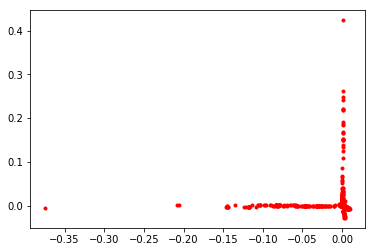

In [18]:
plt.plot(eigen_map[:,0],eigen_map[:,1], 'r.')

**Answer/Comments:**<br>
We have tried doing this part and the following with the combinatorial and the normalized Laplacian. We think that the plot is visually more relevant with the normalized Laplacian, so we have kept this one. <br>

We embed our graph, using the second and third eigenvectors. We don't take the first one since it is constant, so it does not carry information about the graph. The second and third carry information about the connectiveness of the graph. Since we only have two dimensions we chose these two ones. <br>

From the plot, we clearly see two groups of points, aligned along each direction. We can even distinguish three groups, since a lot of points are located in the corner.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

In this case $Z$ is the data matrix, $N$ is the number of data points and $d$ the dimension of each of the data points that we wanted to reduce. 

The embedding Z preserves the number of nodes, but it also preserves the *connectiveness* of the nodes, i.e. how components are connected.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

We choose d = 2 because we want a visualization of our graph and we will use d as the dimension to plot the nodes.
"k" is the number of clusters we should observe. It should be linked with the number of labels, but in our case, we do not really know what kind of labels we should face. 

From the plot we got in question 8, we think we should pick k as 2, 3 or 4. We have tried all of these, and 3 seems to be the most relevant value.

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [19]:
clusters = 3
k_eig_val, k_eig_vect = scipy.sparse.linalg.eigsh(laplacian_c, k=clusters, which='SM')
# Normalizing by the degree
diag = np.diag(laplacian_c)
for i in range(clusters):
    k_eig_vect[:, i] /= diag
inter = KMeans(n_clusters=clusters, random_state=0).fit_predict(k_eig_vect)
Z = np.array(inter)

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


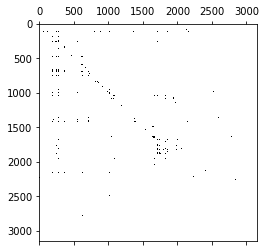

In [20]:
ordered_adj = np.zeros((n_nodes_c, n_nodes_c))
last_idx = 0
for i in range(clusters):
    ordered_adji = adjacency_c[Z==i]
    size = ordered_adji.shape[0]
    ordered_adj[last_idx:last_idx+size] = ordered_adji
    last_idx += size
    
print(ordered_adj)
plt.spy(ordered_adj)
    

(3056, 3154)


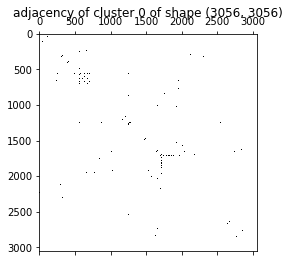

(23, 3154)


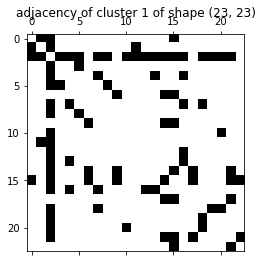

(75, 3154)


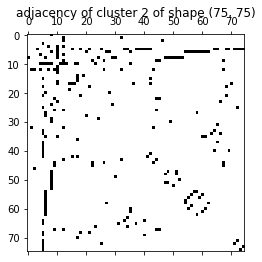

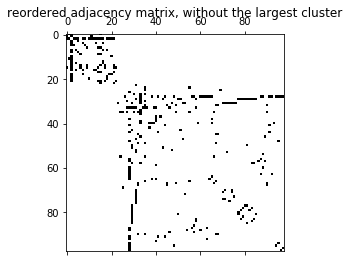

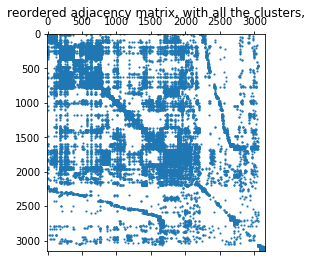

In [21]:
biggest_cluster_size = (Z==0).sum()
ordered_adj_matrix_without_biggest_cluster = np.zeros((n_nodes_c-biggest_cluster_size, n_nodes_c-biggest_cluster_size))
ordered_adj_matrix = np.zeros((n_nodes_c, n_nodes_c))

size = 0
for i in range(clusters):
    current_matrix = adjacency_c[Z==i]
    print(current_matrix.shape)
    current_matrix = current_matrix[:, Z==i]
    if i != 0:
        ordered_adj_matrix_without_biggest_cluster[\
            size - biggest_cluster_size : size-biggest_cluster_size + current_matrix.shape[0],\
            size - biggest_cluster_size : size-biggest_cluster_size + current_matrix.shape[0]] = current_matrix    
    
    ordered_adj_matrix[size:size+current_matrix.shape[0], size:size+current_matrix.shape[0]] = current_matrix      
    size += current_matrix.shape[0]
    plt.title("adjacency of cluster " + str(i) + " of shape " + str(current_matrix.shape))
    plt.spy(current_matrix)
    plt.show()


plt.title("reordered adjacency matrix, without the largest cluster")
plt.spy(ordered_adj_matrix_without_biggest_cluster)
plt.show()
plt.title("reordered adjacency matrix, with all the clusters,")
plt.spy(ordered_adj_matrix, markersize=1)


We expected to see significant changes by reordering of the matrix.

However, the new adjacency matrix is very close to the original one: 97% of the matrix remains unchanged since most of the airports seem to show similar properties (they are widely connected to the other airports) and are assigned to the main cluster. We also note that increasing k, even up to 10,'' does not avoid this phenomenon.

We can distinguish two small clusters, which are both well connected together but poorly connected to the rest of the graph. Geographical or political reasons might explain those two outliers. Further research would be necessary to verify that; maybe in the next milestone!




### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [22]:
# Your code here.

We do not have the ground truth: the flight routes dataset is not labeled.

It is difficult to assess the quality of our clustering. If the purpose is to label our airports, we can state that this clustering is not suitable. Indeed, almost all the points receive the same label.

However, if the goal is to identify small groups of similar airports, this clustering might be adapted.



### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

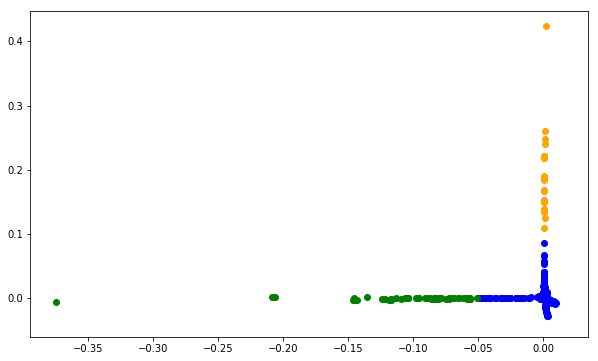

In [23]:
# Your code here.
clust_1 = np.where(Z==0)
clust_2 = np.where(Z==1)
clust_3 = np.where(Z==2)
#clust_4 = np.where(Z==3)

a1 = np.squeeze(np.take(eigen_map, clust_1, 0))
a2 = np.squeeze(np.take(eigen_map, clust_2, 0))
a3 = np.squeeze(np.take(eigen_map, clust_3, 0))
#a4 = np.squeeze(np.take(eigen_map, clust_4, 0))

plt.figure(figsize = (10,6))
plt.scatter(a1[:,0],a1[:,1], color='blue')
plt.scatter(a2[:,0],a2[:,1], color='orange')
plt.scatter(a3[:,0],a3[:,1], color='green')
#plt.scatter(a4[:,0],a4[:,1], color='red')

#plt.ylim((-0.03, 0.03))
#plt.xlim((-0.05, 0.05))


### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**

Eigenvectors and Eigenvalues of the graph Laplacian carry information about the nodes and their connectiveness. Eigenvalues tell us how much connected are our nodes and eigenvectors describe a new orthogonal basis. Hence it is a good metric to reduce dimension of our data space, while keeping the most important information.

Yes, of course there are plenty of other ways to cluster our graph. As an example, we could simply use the latitude and longitude to cluster points according to their locations, regardless of their connectivity, ie their routes.